In [ ]:
import common.star_api.design_manager as dm
import common.visualization as viz
import pandas as pd
import numpy as np
import re
from boruta import BorutaPy
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

work_dir = Path(r"/u/bsbnk1/models/aaron/svd")
name = "svd_proj"
version = "19.02.009-R8"

In [ ]:
# Hack to get around outdated use of np.int in boruta package
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

def plot_boruta(study: dm.Study):
    continuous = [p for p in study.parameters if p.type == dm.Parameter.Type.CONTINUOUS]
    param_names = [p.name for p in continuous]

    successful = study.get_design_set("Successful").data_frame()

    param_names_adjusted = []
    for p in param_names:
        for c in successful.columns:
            regex = f"^{p}( \(.*\))?$"
            if re.match(regex, c):
                param_names_adjusted.append(c)

    param_values = successful[param_names_adjusted]

    response = successful["Cl"]
    
    #######

    ### setup Boruta
    forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

    boruta = BorutaPy(
    estimator = forest,
    n_estimators = 'auto',
    max_iter = 50 # number of trials to perform
    )

    ### fit Boruta (it accepts np.array, not pd.DataFrame)
    boruta.fit(np.array(param_values), np.array(response))

    ### print results
    accepted = param_values.columns[boruta.support_].to_list()
    print('Accepted features:', accepted)

    undecided = param_values.columns[boruta.support_weak_].to_list()
    print('Undecided features', undecided)

In [172]:
def get_param_names(study: dm.Study):
    continuous = [p for p in study.parameters if p.type == dm.Parameter.Type.CONTINUOUS]
    param_names = [p.name for p in continuous]
    successful = study.get_design_set("Successful").data_frame()

    param_names_adjusted = []
    for p in param_names:
        for c in successful.columns:
            regex = f"^{p}( \(.*\))?$"
            if re.match(regex, c):
                param_names_adjusted.append(c)
    return param_names_adjusted


def get_param_values(study: dm.Study):
    successful = study.get_design_set("Successful").data_frame()
    param_values = successful[get_param_names(study)]
    return param_values;

def calc_boruta(study: dm.Study):
    params = get_param_values(study)
    response = study.get_design_set("Successful").data_frame()["Cd"]

    ### initialize hits counter
    hits = np.zeros((len(params.columns)))

    rows_list = []
    param_names = get_param_names(study)

    ### repeat 50 times
    for iter_ in range(50):
        
        ### make params_shadow by randomly permuting each column of parameter values
        np.random.seed(iter_)
        params_shadow = params.apply(np.random.permutation)
        params_boruta = pd.concat([params, params_shadow], axis = 1)

        ### fit a random forest (suggested max_depth between 3 and 7)
        forest = RandomForestRegressor(max_depth = 5, random_state = 42)
        forest.fit(params_boruta, response)

        ### store feature importance
        feat_imp_params = forest.feature_importances_[:len(params.columns)]
        feat_imp_shadow = forest.feature_importances_[len(params.columns):]
        imp_series = pd.Series(feat_imp_params, index=param_names)
        dict1 = {}
        dict1.update(imp_series)
        rows_list.append(dict1)

        ### MIRA (cutoff to mark a feature as accepted)
        cutoff = feat_imp_shadow.max()
        #print(cutoff)

        ### compute hits for this trial and add to counter
        hits += (feat_imp_params > cutoff)

    zscore_hist = pd.DataFrame(rows_list)
    sort_order = zscore_hist.mean().sort_values()
    zscore_sorted = zscore_hist.reindex(sort_order.index, axis=1)
    
    hits_series = pd.Series(hits, index=param_names, dtype=int)
    dict2 = {}
    dict2.update(hits_series)
    hits_list = []
    hits_list.append(dict2)
    hits_df = pd.DataFrame(hits_list)
    hits_sorted = hits_df.reindex(sort_order.index, axis=1)
    hits_filtered = hits_sorted.loc[:, hits_sorted.loc[0] > 19]
    zscore_filtered = zscore_sorted.loc[:, hits_sorted.loc[0] > 19]
    
    colors = []
    for h in hits_filtered:
        if hits_filtered[h].iloc[0] < 20:
            colors.append("black")
        elif hits_filtered[h].iloc[0] < 31:
            colors.append("yellow")
        else:
            colors.append("green")
    return zscore_filtered,colors

In [222]:
def plot_box(zscore_hist, colors):
    fig = plt.figure(figsize =(15, 7))
    plt.yscale("log")
    plt.xticks(rotation=45, ha='right')
    plt.title("Boruta Algorithm - Box and Whiskers Plot")
    plt.ylabel("Z Score")
    plt.xlabel("Parameters")
    box = plt.boxplot(np.array(zscore_hist), tick_labels=zscore_hist.keys(), patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

In [236]:
def plot_violin(zscore_hist, colors):
    fig, ax = plt.subplots(nrows = 1,
                            ncols = 1,
                            figsize = (5, 7),
                            sharey = True)

    fig.set_size_inches(15,7)
    ax.set_title('Boruta Algorithm - Violin Plot')
    ax.set_ylabel('Z Score')
    ax.set_yscale("log")
    ax.set_xlabel('Parameters')
    ax.set_xticks(np.arange(1, len(zscore_hist.keys()) + 1), labels=zscore_hist.keys(), rotation=45)

    violin = ax.violinplot(np.array(zscore_hist), showmedians=True)
    j = 0
    for i, pc in enumerate(violin["bodies"], 1):
        pc.set_facecolor(colors[j])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        j += 1
    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)


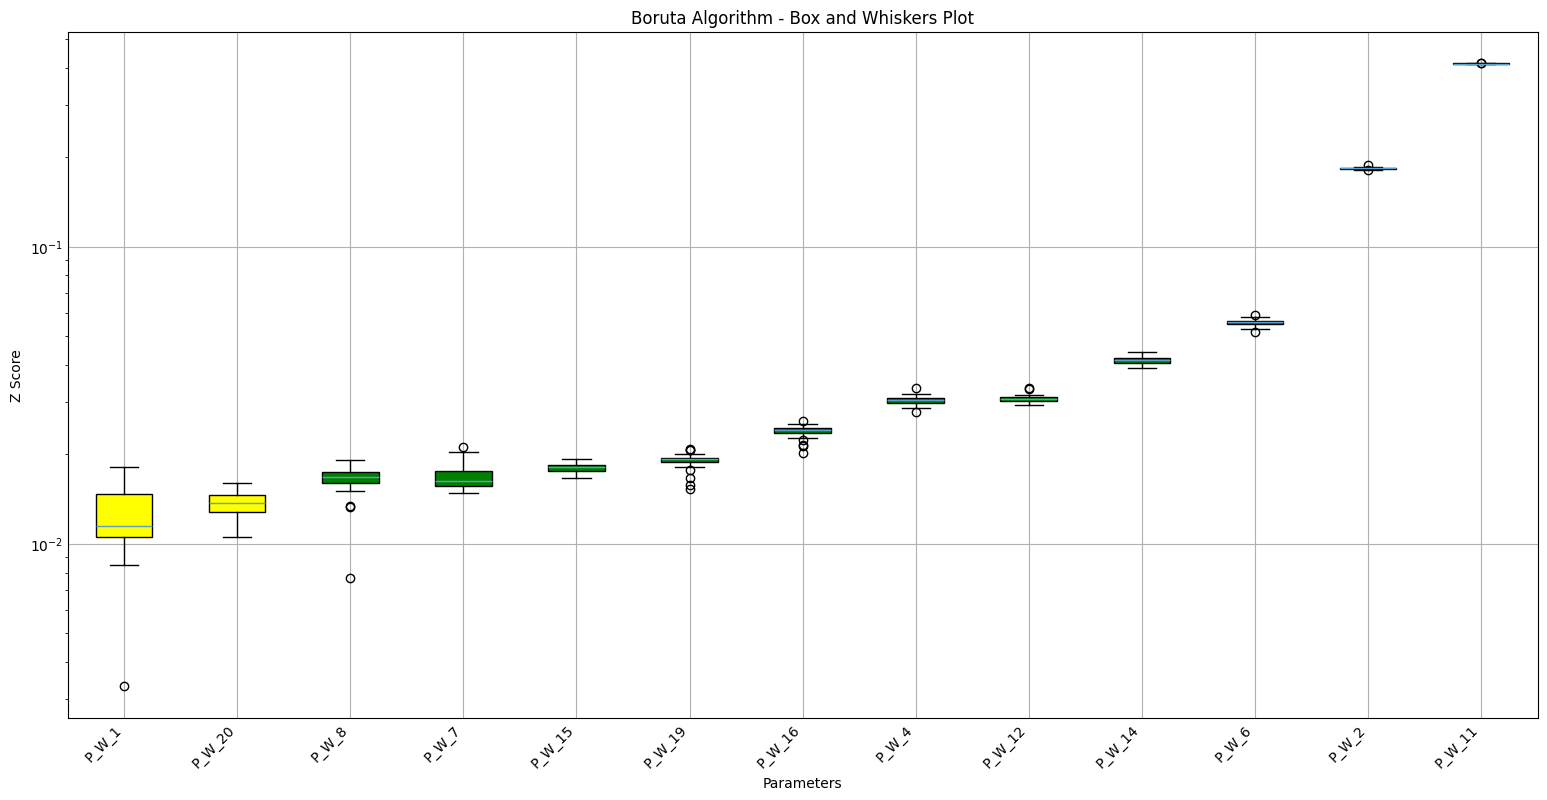

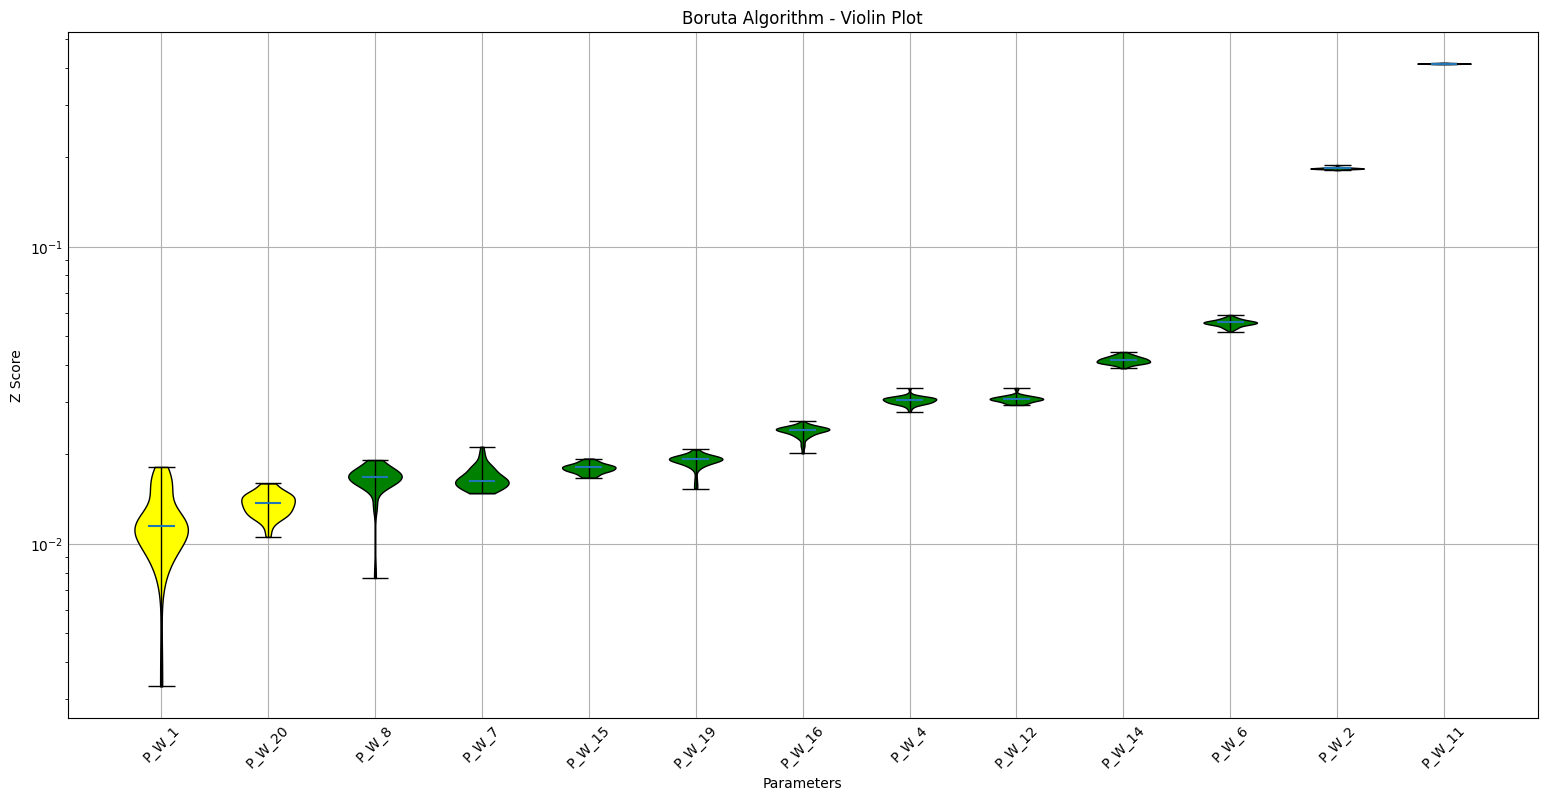

In [237]:
dmprj = dm.DesignManagerProject.get_proj_distrib(work_dir=work_dir, dmprj=name, distrib=r"/install/STAR-CCMP/lin64-r8/19.02.009_01/STAR-CCM+19.02.009-R8/star/bin/starccm+")
study = dmprj.studies[0]
zscore_hist,colors = calc_boruta(study)
plot_box(zscore_hist, colors)
plot_violin(zscore_hist,colors)